In [1]:
##########################
# Our unsuccessful attempt to use log likelihood loss. This is a much older version of this 
# code. Look for comments below for import cells/lines to focus on. I changed the loss function
# but I never fully debugged it. 

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.contrib import rnn

In [2]:
readfile = '~/python/tensorflow/JolleFishData/170202_pi11_SOLI_S17_F175_TR.csv'
model_path = 'ModelCheckpoints/four_border_distance_pred_delta_xy-2x128.ckpt'

# Training parameters
learning_rate = 0.001
dropout = 0.2
n_epochs = 100
batch_size = 512
display_step = 10

# Network parameters
n_input = 4            # number of dimensions in input
n_output = 2           # number of dimensions in output
n_per_hidden = 32     # number of nodes per hidden layer
    # Note: we require that all hidden layers have the same number of nodes
n_hidden_layers = 2    # number of hidden layers
window_length = 100    # length of lookback window to give the LSTM

In [3]:
def download_data(filename):
    """download the csv file stored at 'filename'.
    Drop unnecessary columns."""
    data = pd.read_csv(readfile, sep=",", header=0, index_col=4)  # 'frame' is the 5th column in the csv
    data = data.drop(['date', 'test', 'session', 'tank'], axis=1)
        # these columns are constant over the whole file
        # remaining columns: 'x', 'y', 'borderdistance', 'displacement', 'distmoved', 'speed', 'orientation', 'heading'
    return data
    
def add_wall_distances(data):
    """Add columns to dataframe 'data' that indicate fish's
    distance from each of the four walls.
    Includes sanity check to be verified by the user,
    to ensure that inferred extremum values seem reasonable."""
    min_possible_x = (data['x'] - data['borderdistance']).min()
    min_observed_x = data['x'].min()
    max_possible_x = (data['x'] + data['borderdistance']).max()
    max_observed_x = data['x'].max()
    min_possible_y = (data['y'] - data['borderdistance']).min()
    min_observed_y = data['y'].min()
    max_possible_y = (data['y'] + data['borderdistance']).max()
    max_observed_y = data['y'].max()

    # TODO: pretty-ify this to make it more user-friendly
    print('Sanity check: do these values look reasonable to you?')
    print('Inferred min x: ' + str(min_possible_x) + '; observed min x: ' + str(min_observed_x))
    print('Inferred max x: ' + str(max_possible_x) + '; observed max x: ' + str(max_observed_x))
    print('Inferred min y: ' + str(min_possible_y) + '; observed min y: ' + str(min_observed_y))
    print('Inferred max y: ' + str(max_possible_y) + '; observed max y: ' + str(max_observed_y))
    
    data['xmin_borderdistance'] = data['x'] - min_possible_x
    data['xmax_borderdistance'] = max_possible_x - data['x']
    data['ymin_borderdistance'] = data['y'] - min_possible_y
    data['ymax_borderdistance'] = max_possible_y - data['y']
    
    return data

def add_delta_position(data):
    data['delta_x'] = data['x'].diff()
    data['delta_y'] = data['y'].diff()
    
    data = data.dropna()
    
    return data

In [4]:
def normalize_windows(windows):
    """normalize the data in a given window, so that all points except possibly the last lie in [0,1]"""
    normalized_windows = []
    for window in windows:
        mins = window[:-1,:].min(axis=0)   # leave out the last row when normalizing
        maxes = window[:-1,:].max(axis=0)  # leave out the last row when normalizing
        normalized_window = (window-mins)/(maxes-mins)
        normalized_windows.append(normalized_window)
    return normalized_windows

def partition_windows(windows, window_length, train_percent, valid_percent, test_percent):
    n_windows = len(windows)
    possible_overlap = 2*window_length
    n_windows -= possible_overlap
    
    n_train = n_windows*train_percent//100
    n_valid = n_windows*valid_percent//100
    n_test  = n_windows*test_percent//100

    train = windows[:n_train,:,:]
    valid = windows[n_train+window_length:n_train+n_valid+window_length,:,:]
    test  = windows[n_train+n_valid+2*window_length:,:,:]
    
    return train, valid, test
    
# TODO: find way to preserve column headers within windows
def preprocess_data(data, window_length=window_length, normalize=False):
    """break into windows, each of length 'window_length'"""

    windows = []
    for index in range(len(data) - window_length):
        windows.append(np.array(data.iloc[index:index+window_length,:]))
    
    if normalize:
        windows = normalize_windows(windows)
    
    windows = np.array(windows)
    
    # 80% training, 10% test, 10% validation
    train, valid, test = partition_windows(windows, window_length, 80, 10, 10)

    # randomize the order
    np.random.shuffle(train)
    np.random.shuffle(valid)
    np.random.shuffle(test)
    
    # select data of interest:
        # 'xmin_borderdistance', 'xmax_borderdistance', 'ymin_borderdistance', 'ymax_borderdistance'
        # for input, and
        # 'x', 'y' for output
    # x is everything except last row, y is the last row
    x_train = train[:, :-1, 8:12]
    y_train = train[:,  -1,12:]
    x_valid = valid[:, :-1, 8:12]
    y_valid = valid[: , -1,12:]
    x_test  =  test[: ,:-1, 8:12]
    y_test  =  test[: , -1,12:]

    return x_train, y_train, x_valid, y_valid, x_test, y_test

In [5]:
def plot_fit(true_data, predicted_data):
    slope = 1
    intercept = 0

    n_points = len(true_data)
    for series_index in range(true_data.shape[1]):
        x_data = true_data[:,series_index].reshape(n_points)
        y_data = predicted_data[:,series_index].reshape(n_points)
        abline = [slope * x + intercept for x in x_data]  # line of slope 1 and y-intercept 0

        print("\nDisplaying graph for dataseries " + str(series_index) + ":")
        plt.scatter(x_data, y_data, color='black')
        plt.plot(np.unique(x_data), np.poly1d(
            np.polyfit(x_data, y_data, 1))(np.unique(x_data)), color='red')  # line of best fit
        plt.plot(x_data, abline, color='blue')  

        plt.xlabel('Actual value')
        plt.ylabel('Predicted value')
        plt.show()

In [6]:
# Return a random window
def get_next_window(x_data, y_data):
    index = np.random.randint(0, len(x_data))
    inputs = x_data[index,:,:]
    output = y_data[index,:] 
    return inputs, output
    
# Generate a batch of batch_size random windows
def get_new_batch(x_data, y_data, batch_size):
    inputs = np.empty((batch_size, window_length-1, n_input))
    outputs = np.empty((batch_size, n_output))
    for index in range(batch_size):
        inputs[index,:,:], outputs[index,:] = get_next_window(x_data, y_data)
    return inputs, outputs

# Cell to Focus On

In [36]:
## This is the cell to focus on. Everything else is basically the same or worse.

gaussian_parameters = 5

graph = tf.Graph()

with graph.as_default():

    # Input data
    x_batch_placeholder = tf.placeholder(tf.float32,
                                      shape=(None, window_length-1, n_input))
        # None so that able to hold differently sized batches
    y_batch_placeholder = tf.placeholder(tf.float32, shape=(None, n_output))
        # None so that able to hold differently sized batches
    dropout_placeholder = tf.placeholder(tf.float32)

    # Variables to be trained
    weights = tf.Variable(tf.truncated_normal([n_per_hidden, gaussian_parameters]))
    biases = tf.Variable(tf.zeros([n_output]))
    
    # Build graph
    cells = []
    for _ in range(n_hidden_layers):
        cell = rnn.BasicLSTMCell(n_per_hidden)
        cell = rnn.DropoutWrapper(cell, output_keep_prob=1.0 - dropout_placeholder)
        cells.append(cell)
    cell = rnn.MultiRNNCell(cells)
    
    # Define ops to run forward pass
    outputs, states = tf.nn.dynamic_rnn(cell, x_batch_placeholder, dtype=tf.float32)
    logits = tf.matmul(outputs[:,-1,:], weights)
    print(outputs.shape)
    
    ###################################################################
    ### FOCUS ON THE CODE HERE
    #
    # Parameters of the gaussian that I would like to predict.
    mu1 = tf.slice(logits,[0,0],[-1,1])
    mu2 = tf.slice(logits,[0,1],[-1,1])
    sigma1 = tf.exp(tf.slice(logits,[0,2],[-1,1]))
    sigma2 = tf.exp(tf.slice(logits,[0,3],[-1,1]))
    rho = tf.tanh(tf.slice(logits,[0,4],[-1,1]))
    #
    # Calculating the loss 
    denominator = -tf.log(tf.maximum(2*np.pi*tf.multiply(sigma1,sigma2),tf.exp(-20.0)))-tf.log(tf.maximum(tf.sqrt(1-tf.square(rho)),tf.exp(-20.0)))
    Z = tf.square(tf.div(y_batch_placeholder[0]-mu1,tf.maximum(sigma1,tf.exp(-20.0))))+tf.square(tf.div(y_batch_placeholder[1]-mu2,tf.maximum(sigma2,tf.exp(0.0))))
    -2*tf.div(tf.multiply(tf.multiply(y_batch_placeholder[0]-mu1,y_batch_placeholder[1]-mu2),rho),tf.maximum(tf.multiply(sigma1,sigma1),tf.exp(-20.0)))
    numerator = tf.div(-Z,tf.maximum(2*(1-tf.square(rho)),tf.exp(-20.0)))
    cost = -tf.reduce_sum(denominator+numerator)
    ###################################################################
                         
    # -tf.log(mv_gaussian.prob(y_batch_placeholder))
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)
    
    # Define op to initialize global variables
    init = tf.global_variables_initializer()
    
    # Define Saver op class to save and restore model
    saver = tf.train.Saver()

(?, 99, 32)
(?, 5)
(?, 1)


In [37]:
def train_model(
    n_epochs=n_epochs,
    display_step=display_step,
    learning_rate=learning_rate,
    batch_size=batch_size,
    graph=graph,
    restore_from_save=True,
    restore_path=model_path,
    save_when_finished=True,
    save_path=model_path):
    
    # Launch the graph
    with tf.Session(graph=graph) as sess:
        if restore_from_save:
            try:
                saver.restore(sess, restore_path)
                print("Model successfully restored from %s.\nResuming training." % restore_path)
            except tf.errors.NotFoundError:
                print("Save file not found.\nInitializing graph from scratch instead.")
                sess.run(init)
                print("Global variables initialized.\nCommencing training.")
        else:
            sess.run(init)
            print("Global variables initialized.\nCommencing training.")

        # Keep training until reach max iterations
        for epoch_idx in range(n_epochs):
            _x_batch, _y_batch = get_new_batch(x_train, y_train, batch_size)

            # Run optimization op (backprop)
            feed_dict = {x_batch_placeholder: _x_batch, y_batch_placeholder: _y_batch, dropout_placeholder: dropout}
            _train_cost, _ = sess.run([cost, optimizer], feed_dict=feed_dict)

            if epoch_idx % display_step == 0:
                _valid_cost = sess.run(
                    cost, feed_dict={x_batch_placeholder: x_valid, y_batch_placeholder: y_valid, dropout_placeholder: dropout})
                print("Epoch " + str(epoch_idx) + ", Minibatch cost = " + \
                      "{:.6f}".format(_train_cost))
                print("Epoch " + str(epoch_idx) + ", Validation set cost = " + \
                      "{:.6f}".format(_valid_cost))

        if save_when_finished:
            # Save model weights to disk
            _save_path = saver.save(sess, save_path)
            print("Model saved in file: %s" % _save_path)

        # Plot fit on validation data
        print("\nCurrent validation performance:")
        plot_fit(y_valid, logits.eval(feed_dict={x_batch_placeholder: x_valid, dropout_placeholder: 0}))

In [9]:
def extract_wall_distances(prediction, seed):
    new_wall_distances = np.zeros(4)
    new_wall_distances[0] = seed[-1,0]+prediction[0,0]  # new distance from min x
    new_wall_distances[1] = seed[-1,1]-prediction[0,0]  # new distance from max x
    new_wall_distances[2] = seed[-1,2]+prediction[0,1]  # new distance from min y
    new_wall_distances[3] = seed[-1,3]-prediction[0,1]  # new distance from max y
    
    new_coords = np.array([new_wall_distances[0], new_wall_distances[2]])
    
    return new_wall_distances, new_coords
    
def generate_next_point(seed, sess):
    feed_dict = {x_batch_placeholder: seed, dropout_placeholder: 0}
    _logits = logits.eval(session=sess, feed_dict=feed_dict)
    return _logits
    
def shift_seed(old_seed, new_row):
    return np.vstack([old_seed[1:,:], new_row])
    
def generate_prediction(seed, prediction_length, restore_path=model_path, progress_counter=20):
    """Starting from an unnormalized seed sequence and generate a new sequence of positions"
    Params:
        seed: ndarray, shape (1, window_length-1, n_input)
        prediction_length: integer, number of desired timesteps to generate
        restore_path: string, location from which to load saved graph state
        progress_counter: integer, indicates number of intervals to print progress in generating sequence
    Returns:
        array of predicted locations, of shape shape (prediction_length, n_output)
    """
    with tf.Session(graph=graph) as sess:
        # load the variables
        try:
            saver.restore(sess, restore_path)
            print("Model successfully restored from %s.\nGenerating sequence." % restore_path)
        except tf.errors.NotFoundError:  # TODO: add type of error
            print("Save file not found.\nExiting.")
            return
        
        predictions = []
        show_interval = prediction_length//progress_counter
        
        for index in range(prediction_length):
            if index % show_interval == 0:
                print("Generated", index, "of", prediction_length, "data points.")
            batch_seed = seed.reshape(1, window_length-1, n_input)  # cast to batch format (batch of size 1)
            prediction = generate_next_point(batch_seed, sess)
            wall_distances, pred_coords = extract_wall_distances(prediction, seed)
            predictions.append(pred_coords)
            seed = shift_seed(seed, wall_distances)
        print("Done!")
        
        return np.array(predictions)

In [10]:
# Load data, add required columns
all_data = download_data(readfile)
all_data = add_wall_distances(all_data)
all_data = add_delta_position(all_data)

# Create training, validation, and test sets
x_train, y_train, x_valid, y_valid, x_test, y_test = preprocess_data(
    all_data, window_length=window_length, normalize=False)

Sanity check: do these values look reasonable to you?
Inferred min x: 0.0; observed min x: 10.2
Inferred max x: 775.0; observed max x: 772.4
Inferred min y: 0.0; observed min y: 3.9
Inferred max y: 515.3; observed max y: 507.4


Global variables initialized.
Commencing training.
Epoch 0, Minibatch cost = 8828679.000000
Epoch 0, Validation set cost = 692385.687500
Epoch 10, Minibatch cost = 26557.050781
Epoch 10, Validation set cost = 231090.890625
Epoch 20, Minibatch cost = 42755.109375
Epoch 20, Validation set cost = 153477.828125
Epoch 30, Minibatch cost = 12658.361328
Epoch 30, Validation set cost = 131121.218750
Epoch 40, Minibatch cost = 8801.578125
Epoch 40, Validation set cost = 81499.171875
Epoch 50, Minibatch cost = 5242.420898
Epoch 50, Validation set cost = 65564.031250
Epoch 60, Minibatch cost = 6033.384277
Epoch 60, Validation set cost = 55754.050781
Epoch 70, Minibatch cost = 22851.015625
Epoch 70, Validation set cost = 42926.484375
Epoch 80, Minibatch cost = 15352.579102
Epoch 80, Validation set cost = 38293.906250
Epoch 90, Minibatch cost = 16096.714844
Epoch 90, Validation set cost = 34038.382812
Epoch 100, Minibatch cost = 6332.613281
Epoch 100, Validation set cost = 27745.201172
Epoch 110, M

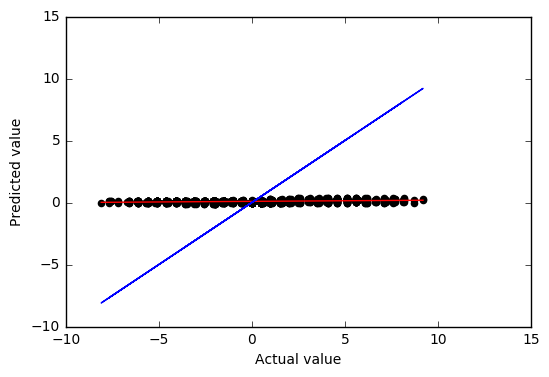


Displaying graph for dataseries 1:


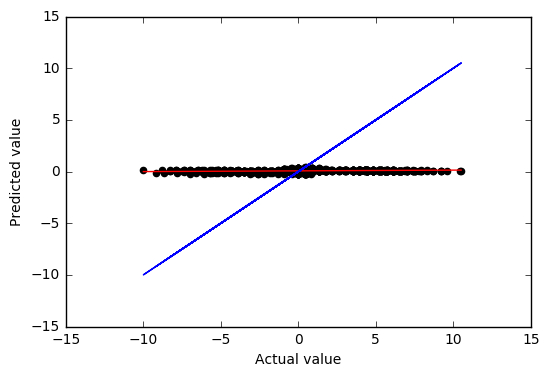

In [39]:
train_model(n_epochs=500,display_step=10,learning_rate=0.0001, restore_from_save=False)

In [40]:
filename = 'predict2.csv'
seed = x_train[0]
predictions = generate_prediction(seed, 5000, restore_path=model_path, progress_counter=20)
np.savetxt(filename, predictions, delimiter=",")

INFO:tensorflow:Restoring parameters from ModelCheckpoints/four_border_distance_pred_delta_xy-2x128.ckpt
Model successfully restored from ModelCheckpoints/four_border_distance_pred_delta_xy-2x128.ckpt.
Generating sequence.
Generated 0 of 5000 data points.
Generated 250 of 5000 data points.
Generated 500 of 5000 data points.
Generated 750 of 5000 data points.
Generated 1000 of 5000 data points.
Generated 1250 of 5000 data points.
Generated 1500 of 5000 data points.
Generated 1750 of 5000 data points.
Generated 2000 of 5000 data points.
Generated 2250 of 5000 data points.
Generated 2500 of 5000 data points.
Generated 2750 of 5000 data points.
Generated 3000 of 5000 data points.
Generated 3250 of 5000 data points.
Generated 3500 of 5000 data points.
Generated 3750 of 5000 data points.
Generated 4000 of 5000 data points.
Generated 4250 of 5000 data points.
Generated 4500 of 5000 data points.
Generated 4750 of 5000 data points.
Done!
